In [181]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text
from operator import itemgetter
from IPython.core.display import HTML


In [182]:
# Берем датасет, будем предсказывать погоду
data = pd.read_csv('seattle-weather.csv')
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [183]:
#Узнаем все уникальные явления погоды
TARGET_LABELS = sorted(data['weather'].unique())
TARGET_LABELS

['drizzle', 'fog', 'rain', 'snow', 'sun']

In [184]:
#Возьмем признаки, по которым будем предсказывать погоду, и поставим их значения в промежутке от 0 до 1
le = LabelEncoder()
mms = MinMaxScaler()
data['precipitation'] = mms.fit_transform(data[['precipitation']])
data['temp_max'] = mms.fit_transform(data[['temp_max']])
data['temp_min'] = mms.fit_transform(data[['temp_min']])
data['wind'] = mms.fit_transform(data[['wind']])
data['weather'] = le.fit_transform(data['weather'])
data = data.drop(columns=['date'])
data.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.000000,0.387097,0.476378,0.472527,0
1,0.194991,0.327957,0.389764,0.450549,2
2,0.014311,0.357527,0.562992,0.208791,2
3,0.363148,0.370968,0.500000,0.472527,2
4,0.023256,0.282258,0.389764,0.626374,2


In [185]:
#Сделаем тестовые значения
TARGET_KEY = 'weather'
X_data, y_data = data.drop(columns=[TARGET_KEY]), data[[TARGET_KEY]]
X_test, X_train, y_test, y_train = train_test_split(X_data, y_data)

In [186]:
# Задает шаблон таблиц точности
def class_accuracy_score(y_true: pd.DataFrame, y_pred: np.ndarray):
    unique, counts = np.unique(y_true[TARGET_KEY], return_counts=True)
    y_true_values = y_true[TARGET_KEY].values
    result = {}
    for value in unique:
        result[value] = 0
    for index in range(len(y_true_values)):
        if y_true_values[index] == y_pred[index]:
            result[y_true_values[index]] += 1
    for index in range(len(unique)):
        result[unique[index]] /= counts[index]
    result['all'] = accuracy_score(y_true, y_pred)
    return result

In [187]:
#Метод логистической регрессии
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

c:\Users\miss-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [188]:
# Векторный метод
svm = SVC(kernel='linear', random_state=0)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

c:\Users\miss-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [189]:
# Метод дерева решений
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [ ]:
#Покажем с помощью таблиц точности на сколько точно предсказанны данные

In [190]:
#Выведем данные, которые покажет первый метод
lr_accuracy_scores = class_accuracy_score(y_test, y_pred_lr)
pd.DataFrame.from_dict(lr_accuracy_scores, orient='index', columns=['accuracy'])

,accuracy
0,0.000000
1,0.000000
2,0.798780
3,0.000000
4,0.819533
all,0.711416


In [191]:
#Выведем данные, которые покажет второй метод
svm_accuracy_scores = class_accuracy_score(y_test, y_pred_svm)
pd.DataFrame.from_dict(svm_accuracy_scores, orient='index', columns=['accuracy'])

,accuracy
0,0.000000
1,0.000000
2,0.798780
3,0.000000
4,0.828025
all,0.715068


In [192]:
#Выведем данные, которые покажет третий метод
dt_accuracy_scores = class_accuracy_score(y_test, y_pred_dt)
pd.DataFrame.from_dict(dt_accuracy_scores, orient='index', columns=['accuracy'])

,accuracy
0,0.125000
1,0.120000
2,0.908537
3,0.588235
4,0.732484
all,0.745205


In [ ]:
#Покажем с помощью матриц на сколько точно предсказанны данные

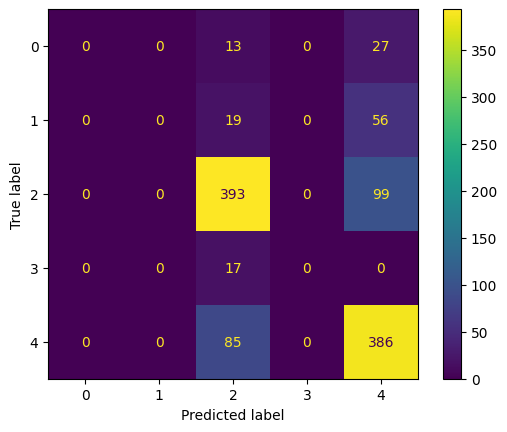

In [193]:
#Выведем данные, которые покажет первый метод
lr_confusion_matrix = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)

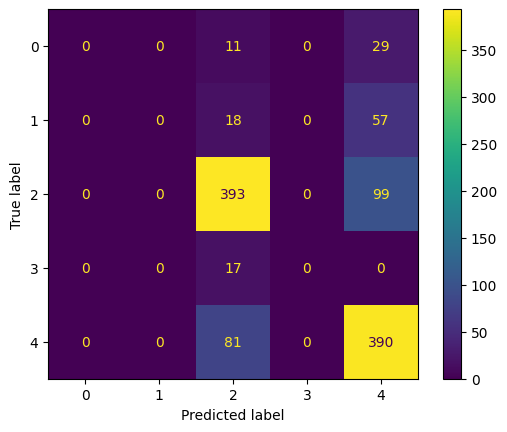

In [194]:
#Выведем данные, которые покажет второй метод
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)

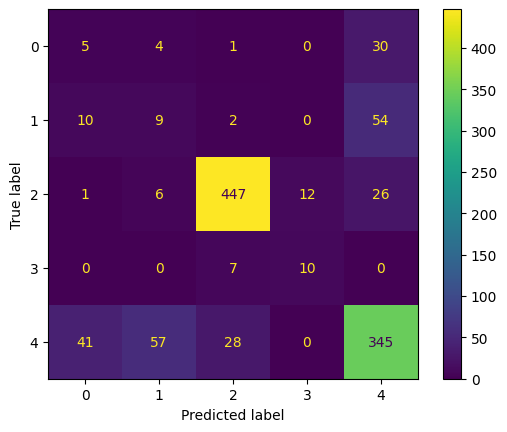

In [195]:
#Выведем данные, которые покажет третий метод
dt_confusion_matrix = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)

In [196]:
#Вывод важности признаков в виде графика
def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

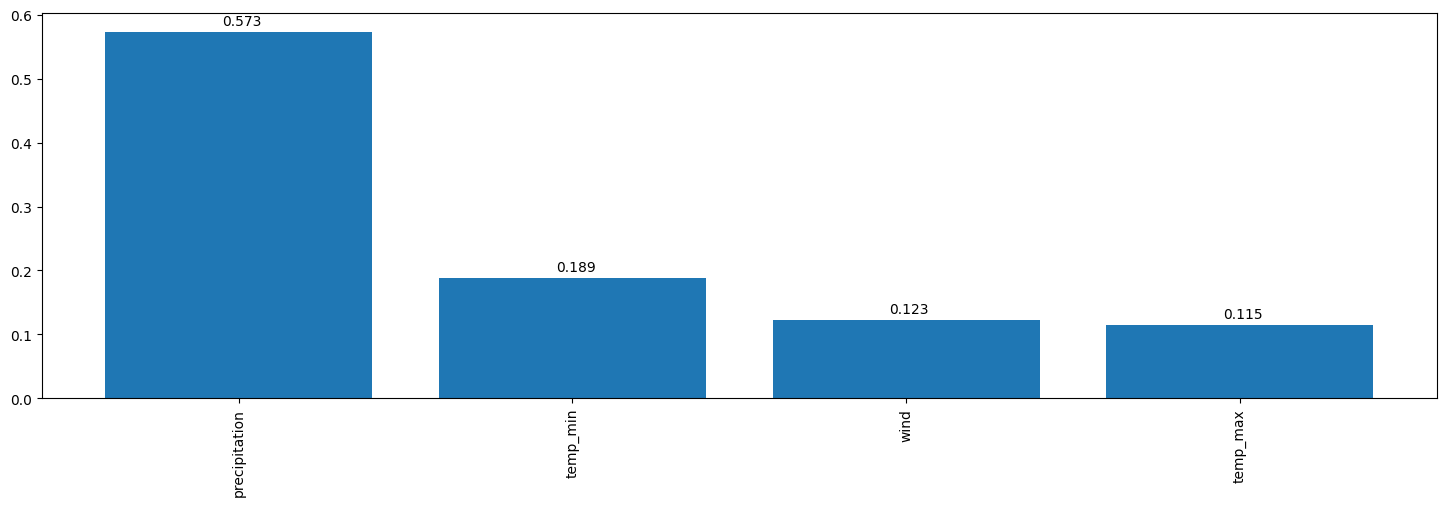

(['precipitation', 'temp_min', 'wind', 'temp_max'],
 [0.5733017237402966,
  0.18890669840450483,
  0.12255669953777323,
  0.11523487831742535])

In [197]:
draw_feature_importances(dt, X_test)

In [198]:
#Выведем дерево решений
graph_data = export_text(dt, feature_names=list(X_test.columns))
HTML('<pre>' + graph_data + '</pre>')